In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from sklearn.metrics import jaccard_score, f1_score
from sklearn.metrics import jaccard_score, f1_score, accuracy_score


In [10]:

def build_model(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(1, (1, 1), activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [3]:
# Load MRI scan and corresponding mask
def load_dataset(folder_path, tumor_type="Giloma", img_size=(128, 128)):
    images, masks = [], []
    tumor_path = os.path.join(folder_path, tumor_type)
    for file in os.listdir(tumor_path):
        if "_mask" not in file:  # Only load original MRI scans
            img_path = os.path.join(tumor_path, file)
            mask_path = os.path.join(tumor_path, file.replace(".png", "_mask.png"))
            
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            image = cv2.resize(image, img_size) / 255.0
            mask = cv2.resize(mask, img_size) / 255.0
            
            images.append(image)
            masks.append(mask)
    
    images = np.expand_dims(np.array(images), axis=-1)
    masks = np.expand_dims(np.array(masks), axis=-1)
    return images, masks

In [4]:

try:
    model = load_model('brain_tumor_segmentation_model.h5')
except:
    model = build_model()

In [5]:

data_folder = "data/data"
images, masks = load_dataset(data_folder, tumor_type="Glioma")

try:
    model.fit(images, masks, epochs=50, batch_size=4, validation_split=0.2)
    model.save('brain_tumor_segmentation_model.h5')
except:
    print("Existing model exists, please remove the .h5 file from directory to run this ")
    pass

Epoch 1/50
Existing model exists, please remove the .h5 file from directory to run this 


In [8]:

def segment_tumor(image):
    image_input = np.expand_dims(image, axis=(0, -1))  # Reshape for model
    prediction = model.predict(image_input)
    predicted_mask = (prediction > 0.5).astype(np.uint8)
    return predicted_mask.squeeze()

# Evaluate segmentation
def calculate_metrics(true_mask, predicted_mask):
    """
    Calculates Dice Similarity Coefficient (DSC) and IoU for segmentation accuracy.
    
    Args:
    true_mask (numpy array): Ground truth binary mask.
    predicted_mask (numpy array): Predicted binary mask.
    
    Returns:
    tuple: Dice Similarity Coefficient (DSC), IoU (Jaccard Index)
    """
    intersection = np.sum(true_mask * predicted_mask)
    union = np.sum(true_mask) + np.sum(predicted_mask)
    
    dice = (2. * intersection) / union if union > 0 else 1.0
    iou = intersection / (np.sum(true_mask) + np.sum(predicted_mask) - intersection) if union > 0 else 1.0
    
    return dice, iou


def evaluate_segmentation(true_mask, predicted_mask):
    dice_score = f1_score(true_mask.flatten(), predicted_mask.flatten())
    jaccard_idx = jaccard_score(true_mask.flatten(), predicted_mask.flatten())
    return dice_score, jaccard_idx

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 Example 1 (Index 374) Scores:
    Dice Score (F1): 0.9212
    IoU: 0.8538
    Accuracy: 0.9977

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 Example 2 (Index 230) Scores:
    Dice Score (F1): 0.9684
    IoU: 0.9387
    Accuracy: 0.9990

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 Example 3 (Index 267) Scores:
    Dice Score (F1): 0.9513
    IoU: 0.9071
    Accuracy: 0.9974

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Example 4 (Index 576) Scores:
    Dice Score (F1): 0.9384
    IoU: 0.8839
    Accuracy: 0.9992

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Example 5 (Index 520) Scores:
    Dice Score (F1): 0.9838
    IoU: 0.9681
    Accuracy: 0.9995



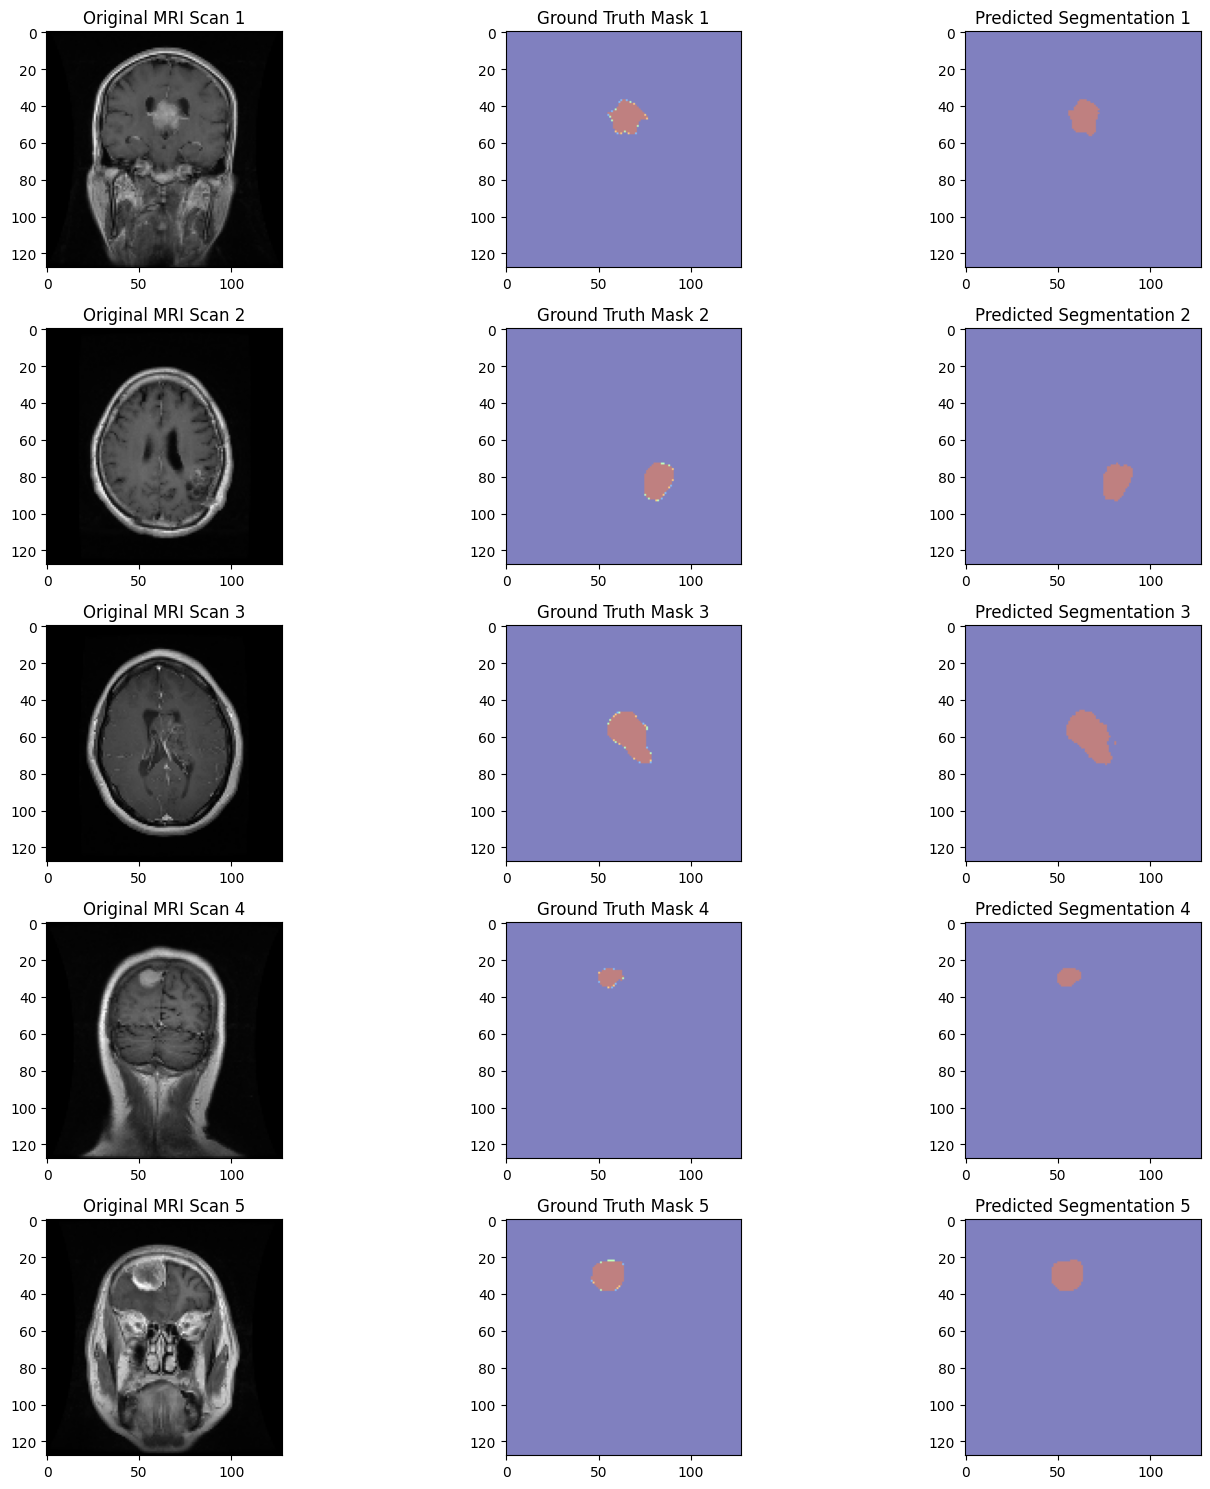

In [14]:
"""
YOU CAN KEEP RUNNING THIS BLOCK TO SEE DIFFERENT RESULTS
    
"""
import random


num_examples = 5
random_indices = random.sample(range(len(images)), num_examples)

plt.figure(figsize=(15, num_examples * 3))

for i, idx in enumerate(random_indices):
    mri_scan = images[idx].squeeze()
    true_mask = masks[idx].squeeze()
    true_mask_bin = (true_mask > 0.5).astype(np.uint8)

    image_input = np.expand_dims(mri_scan, axis=(0, -1))
    prediction = model.predict(image_input)

    prob_map = prediction[0, :, :, 0]  # Raw sigmoid output
    predicted_mask = (prob_map > 0.5).astype(np.uint8)

    # Scores for this example
    dice = f1_score(true_mask_bin.flatten(), predicted_mask.flatten())
    iou = jaccard_score(true_mask_bin.flatten(), predicted_mask.flatten())
    acc = accuracy_score(true_mask_bin.flatten(), predicted_mask.flatten())

    print(f" Example {i+1} (Index {idx}) Scores:")
    print(f"    Dice Score (F1): {dice:.4f}")
    print(f"    IoU: {iou:.4f}")
    print(f"    Accuracy: {acc:.4f}\n")

    # Plot
    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(mri_scan, cmap='gray')
    plt.title(f"Original MRI Scan {i+1}")

    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(true_mask, cmap='jet', alpha=0.5)
    plt.title(f"Ground Truth Mask {i+1}")

    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)
    plt.title(f"Predicted Segmentation {i+1}")

plt.tight_layout()
plt.show()
